# Two-level atomic system: 3 approaches #
In this notebook we will solve a two-level atomic system using three methods: 
* the Liouville equations written by hand and solved analytically or using a solver from the library DifferentialEquations.jl ([see the nice tutorial by Simon Rochester](http://rochesterscientific.com/ADM/AtomicDensityMatrix/tutorial/TwoLevelSystem.html))
* the rate equations for Zeeman coherences (cf. [Blushs and Auzinsh, 2004](https://doi.org/10.1103/PhysRevA.69.063806)) 
* the Master Equation as implmented in QuantumOptics.jl (with some modifications needed, as we shall see).

In [1]:
using LinearAlgebra
using QuantumOptics
#import Pkg; Pkg.add("DifferentialEquations")
using DifferentialEquations
using Plots
plotly()
using Printf 
using QuantumOptics.steadystate

## System description ##
As the name suggests, the two-level atom consists of a ground state $\left| 1 \right>$ and and excited state $\left| 2 \right>$. We will assume that the energy of the first level $\hbar \omega_1=0$ and the energy of the second level is $\hbar \omega=\Delta$. The two levels are coupled by a laser field with Rabi frequency $\Omega_R$. The decay from $\left| 1 \right>$ to $\left| 2 \right>$ is described by a decay rate $\Gamma_{21}$. Furthermore, atoms fly out of the beam at a rate $\gamma$ (fly-through relaxation), which affects both the ground and excited states. It is assumed that the ground state is repopulated at a rate $\lambda$ such that the overall population remains the same. 

The system can be described by a density matrix $\rho$:

$$\rho = \begin{bmatrix}
\rho_{11} & \rho_{12}\\
\rho_{21} & \rho_{22}
\end{bmatrix}$$

The population of level $\left| 1 \right>$ is $\rho_{11}$, and the population of level $\left| 2 \right>$ is $\left| 1 \right>$ is $\rho_{11}$. The matrix elements $\rho_{12}$ and $\rho_{21}$ describe the coherences.

We will enter the parameter values once here: $\Omega_R$, $\Gamma$, $\gamma=\lambda$, and $\Delta$. 

In [3]:
Ωᵣ=1.0+0.0im                # Rabi frequency
Γ=1.0+0.0im                 # decay rate from level 2 to 1.
γ=0.05+0.0im                # fly-through relaxation rate (assume same for all levels)
λ=γ                         # \lambda=\gamma Tr(\rho), and Tr(\rho)=1 for constant population.
Δ=0.1+0.0im                 # laser detuning.
p=[Ωᵣ,Γ,γ,Δ]                # paramter vector
ρ0 = [1.0+0.0im, 0.0+0.0im] # initial state in ground state (when needed)
tspan = (0.0,10.0)          # time span (for time-dependent problems)

(0.0, 10.0)

## Liouville equations ##
The problem described above can be reprented by the following system of differential equations:
$$
\begin{array}{lcl}
\frac{\partial \rho_{11}}{\partial t} &=& \lambda - \gamma \rho_{11} -i\frac{\Omega_R}{2}(\rho_{12}-\rho_{21})+\Gamma \rho_{22} \\
\frac{\partial \rho_{12}}{\partial t} &=& \frac{1}{2}\left[ -\gamma \rho_{12} -(\gamma+\Gamma)\rho_{12}\right] -i\frac{\Omega_R}{2}(\rho_{11}-\rho_{22}) -i\Delta \rho_{12}\\
\frac{\partial \rho_{21}}{\partial t} &=& \frac{1}{2}\left[ -\gamma \rho_{21} -(\gamma+\Gamma)\rho_{21}\right] -i\frac{\Omega_R}{2}(-\rho_{11}+\rho_{22}) +i\Delta \rho_{21}\\
\frac{\partial \rho_{22}}{\partial t} &=& -i\frac{\Omega_R}{2}(-\rho_{12}+\rho{21})-(\gamma + \Gamma)\rho_{22}
\end{array}
$$


In [4]:
# We define the Liouville system
function Liouville!(dρ₂,ρ₂,p,t)
    Ωᵣ,Γ,γ,Δ = p
    dρ₂[1]=γ-γ*ρ₂[1]-1.0im*0.5*Ωᵣ*(ρ₂[2]-ρ₂[3])+Γ*ρ₂[4]
    dρ₂[2]=0.5*( -γ*ρ₂[2]-(γ+Γ)*ρ₂[2] ) - 1.0im*0.5*Ωᵣ*( ρ₂[1] - ρ₂[4] ) - 1.0im*Δ*ρ₂[2]
    dρ₂[3]=0.5*( -γ*ρ₂[3]-(γ+Γ)*ρ₂[3] ) - 1.0im*0.5*Ωᵣ*( -ρ₂[1] + ρ₂[4] ) + 1.0im*Δ*ρ₂[3]
    dρ₂[4]=-(γ+Γ)*ρ₂[4]-1.0im*0.5Ωᵣ*( -ρ₂[2] + ρ₂[3] ) 
end

Liouville! (generic function with 1 method)

### Analytical solution of the Liouville equations ###
The Liouville equations for this system have an exact solution for the steady-state value of the density matrix. 

In [5]:
# exact solution of Liouville system (from Rochester)
ΩR=Ωᵣ
ρ₁₁=((γ+Γ)*((2*γ+Γ)^2+4*Δ^2)+(2*γ+Γ)*ΩR^2)/(((γ+Γ)*((2*γ+Γ)^2+4*Δ^2))+2*(2*γ+Γ)*ΩR^2)
ρ₁₂=(0.0-1.0*im)*(γ+Γ)*(2*γ+Γ-2*(1.0+1.0im)*Δ)*ΩR/(((γ+Γ)*((2*γ+Γ)^2+4*Δ^2))+2*(2*γ+Γ)*ΩR^2)
ρ₂₁=(0.0+1.0*im)*(γ+Γ)*(2*γ+Γ+2*(1.0+1.0im)*Δ)*ΩR/(((γ+Γ)*((2*γ+Γ)^2+4*Δ^2))+2*(2*γ+Γ)*ΩR^2)
ρ₂₂=(2*γ+Γ)*ΩR^2/(((γ+Γ)*((2*γ+Γ)^2+4*Δ^2))+2*(2*γ+Γ)*ΩR^2)
println("ρ₁₁ = ", ρ₁₁)
println("ρ₁₂ = ", ρ₁₂)
println("ρ₂₁ = ", ρ₂₁)
println("ρ₂₂ = ", ρ₂₂)
println("Tr(ρ) = ",ρ₁₁+ρ₂₂)

ρ₁₁ = 0.6868327402135233 + 0.0im
ρ₁₂ = -0.0597864768683274 - 0.26903914590747335im
ρ₂₁ = -0.0597864768683274 + 0.38861209964412813im
ρ₂₂ = 0.31316725978647686 + 0.0im
Tr(ρ) = 1.0 + 0.0im


### Solving the Liouville equations with DifferentialEquations.jl ###
We can also solve the Liouville equations using solvers from Differential Equations. 

#### Steady-state problem ####
First, we will solve the steady-state problem using the solver SSRootfind().  

In [6]:
ρ2₀ = [1.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im]     # initial conditions (not really needed for steady state)
probLiouville = SteadyStateProblem(Liouville!,ρ2₀,p)
sol = solve(probLiouville,SSRootfind())

u: 4-element Vector{ComplexF64}:
    0.6868327402122938 - 1.0547776057540605e-16im
  -0.05978647686767886 - 0.328825622776546im
 -0.059786476867678774 + 0.328825622776546im
    0.3131672597871866 - 6.384439715179834e-17im

#### Time-dependent problem ####
However, we can also solve it as a time-dependent problem. 

┌ Warning: Attribute alias `zlabel` detected in the user recipe defined for the signature (::Matrix{Float64}, ::Matrix{ComplexF64}). To ensure expected behavior it is recommended to use the default attribute `zguide`.
└ @ Plots C:\Users\User\.julia\packages\Plots\SVksJ\src\pipeline.jl:26


┌ Warning: Attribute alias `ylabel` detected in the user recipe defined for the signature (::Matrix{Float64}, ::Matrix{ComplexF64}). To ensure expected behavior it is recommended to use the default attribute `yguide`.
└ @ Plots C:\Users\User\.julia\packages\Plots\SVksJ\src\pipeline.jl:26


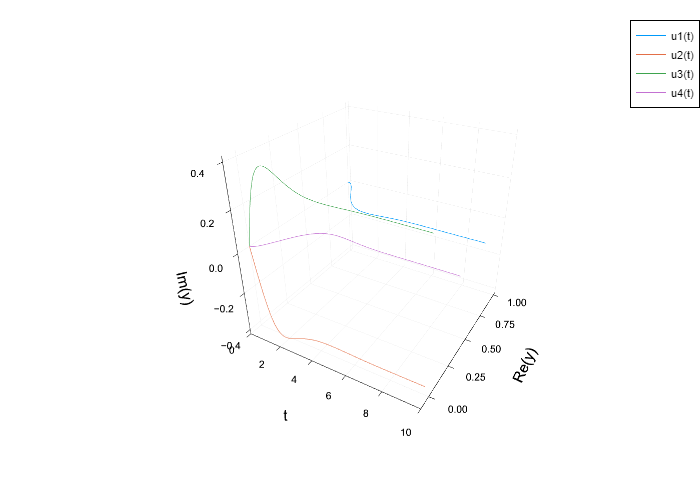

In [7]:
ρ2₀=[1.0+0.0im,0.0+0.0im,0.0+0.0im,0.0+0.0im]
tspan = (0.0,10.0)
probLiouville = ODEProblem(Liouville!,ρ2₀,tspan,p)
sol = solve(probLiouville)
plot(sol)

## Rate equations for Zeeman coherences ##
One can average over the coherence terms in the Liouville equations (cf. [Blushs and Auzinsh, 2004](https://doi.org/10.1103/PhysRevA.69.063806)). This procedure has the advantage or reducing the number of equations, but it is also useful as a way to account for phase fluctuations in the laser beam, which are reduced to a single parameter, the laser linewidth. Details can be found in Blushs and Auzinsh (2004). The result is:
$$\begin{array}{lcl}
    \frac{\partial \rho_{11}}{\partial t} &=& \frac{1}{4}(\Xi_{12}+\Xi_{21})\rho_{22} - \frac{1}{4}(\Xi_{12}+\Xi_{21})\rho_{11}  - \gamma \rho_{11} +\Gamma \rho_{22} + \lambda \\
\frac{\partial \rho_{22}}{\partial t} &=& \frac{1}{4}(\Xi_{21}+\Xi_{12})\rho_{11} - \frac{1}{4}(\Xi_{12}+\Xi_{21})\rho_{22} -(\gamma + \Gamma)\rho_{22} 
\end{array}
$$
where,
$$\begin{array}{lcl}
\Xi_{12}=\frac{\Omega_R^2}{\left(\frac{\Gamma}{2}+\gamma + i\Delta \right)} \\
\Xi_{21}=\frac{\Omega_R^2}{\left(\frac{\Gamma}{2}+\gamma - i\Delta \right)}
\end{array}$$
and the other constants are as defined earlier.

In [8]:
#Divu limenu sistema. Linarda pieeja
function bliv!(dρ,ρ,p,t)
    Ωᵣ,Γ,γ,Δ = p
    Ξ₁₂ = Ωᵣ^2 /((Γ/2)+γ +1.0im*(Δ))   
    Ξ₂₁ = Ωᵣ^2 /((Γ/2)+γ -1.0im*(Δ))    
    dρ[1] = 0.25*( Ξ₁₂ + Ξ₂₁ )*ρ[2] - 0.25*( Ξ₂₁ + Ξ₁₂ )*ρ[1] + Γ*ρ[2] - γ*ρ[1] + γ
    dρ[2] = 0.25*( Ξ₂₁ + Ξ₁₂ )*ρ[1] - 0.25*( Ξ₁₂ + Ξ₂₁ )*ρ[2] - (Γ + γ)*ρ[2]
end

bliv! (generic function with 1 method)

In [9]:
prob = SteadyStateProblem(bliv!,ρ0,p)
sol = solve(prob)

u: 2-element Vector{ComplexF64}:
   0.686832740251305 + 0.0im
 0.31316725980611354 + 0.0im

## Formulating the problem using the Master Equation ##
The two-level problem can be described in a different way that some people may find more intuitive by writing the Hamiltonian as follows:
$$\begin{equation}
\hat{H}=\frac{\Omega_R}{2} \left( \left| 1 \right> \left< 2 \right|+ \left| 2 \right> \left< 1 \right| \right) - \Delta \left| 2 \right> \left< 2 \right|
\end{equation}
$$
Relaxation terms can be included using the Lindblad superoperator, for which we define Jump operators. The Jump operator for decay from level 1 to level 2 is (somewhat counterintuitively):
$$
\hat{J}=\sqrt(\Gamma_{21})\left| 1 \right> \left< 2 \right|
$$
Then the Lindblad superoperator is
$$
\hat{\mathcal{L}}[\rho]=J \rho J^{\dagger} - \frac{1}{2} \left( J^{\dagger}J \rho + \rho J^{\dagger}J \right)
$$

For our two-level system, fly-through relaxation introduces decoherence, which we can describe for each level as
$$
\hat{J}^{fly-through}_k=\sqrt(\gamma)\left| k \right> \left< k \right|.
$$

Then, the system dynamics are described by the equation
$$
\frac{\partial \rho}{\partial t}=-\frac{i}{\hbar}[H,\rho] + \sum_{i}\hat{\mathcal{L}}_i[\rho]
$$

The Library QuantumOptics.jl provides a function called liouvillian that transforms a system defined as above into a matrix *L* such that
$$
\frac{\partial \mathbf{\rho}}{\partial t} = \mathbf{L} \mathbf{\rho},
$$
where $\mathbf{\rho}$ is determined as a vector
$$
\rho = \begin{bmatrix}
\rho_{11} \\ 
\rho_{12} \\
\rho_{21} \\ 
\rho_{22}
\end{bmatrix}
$$
However, the transfer of atoms into and outof the laser beam by fly-through relaxation is not included in this way (only the decoherence introduced in this way), so we have to include it by hand by adding the appropriate terms to the Liouville matrix and by making the problem inhomogeneous, i.e., $\frac{\partial \rho}{\partial t}=-\lambda$, where $\lambda = \gamma$. 

In [10]:
my2levelSystem=NLevelBasis(2)
σ₁₂=transition(my2levelSystem,1,2)   # Laser excitation |1><2|
σ₂₁=transition(my2levelSystem,2,1)   # |2><1|
Γ₂₁=transition(my2levelSystem,1,2)   # excited state relaxation |2><1| 


proj2=transition(my2levelSystem,2,2) # |2><2|
proj1=transition(my2levelSystem,1,1)

J2=[sqrt(Γ)*Γ₂₁,
   (sqrt(γ))*proj1,
   (sqrt(γ))*proj2
  ]
H2=(ΩR/2)*(σ₁₂+σ₂₁) + Δ*proj2 
L=liouvillian(H2,J2) 
DenseL=Array(L.data)
A=DenseL

A[1,1]=A[1,1]-γ            # add terms for fly-through population loss by hand
A[4,4]=A[4,4]-γ            # add terms for fly-through population loss by hand
y=[-λ,0,0,0]               # inhomogeneous term (to account for repopulation of fly-through)
Ainv=inv(A)                # invert matrix
eigen_vectors=Ainv*y

4-element Vector{ComplexF64}:
    0.6868327402135219 + 1.92906189243143e-17im
 -0.059786476868327304 - 0.32882562277580013im
 -0.059786476868327304 + 0.3288256227758001im
    0.3131672597864763 + 0.0im